In [1]:
!pip install nltk


## Task-1

In [2]:
## Task-1


# =========================================
# Sentiment140 Dataset Loading + Preprocessing (Colab, fixed 'punkt_tab')
# =========================================
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

# --- Authenticate with Kaggle ---
print("--- Authenticating with Kaggle ---")
os.makedirs("/root/.kaggle", exist_ok=True)

if os.path.exists("/content/kaggle.json"):
    os.system("cp /content/kaggle.json /root/.kaggle/")
else:
    raise FileNotFoundError("❌ kaggle.json not found in /content/. Please upload it first!")

os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ Kaggle API key configured successfully.")

# --- Download Sentiment140 dataset ---
print("\n--- Downloading Sentiment140 dataset ---")
os.system("kaggle datasets download -d kazanova/sentiment140 -p /content --force")
os.system("unzip -o /content/sentiment140.zip -d /content/")

# --- Initialize tqdm ---
tqdm.pandas()

# --- NLTK Resource Download (with punkt_tab fix) ---
for pkg in ['stopwords', 'punkt', 'punkt_tab', 'wordnet']:
    try:
        nltk.data.find(f'corpora/{pkg}')
    except LookupError:
        nltk.download(pkg, quiet=True)

# --- Step 1: Load and Explore Data ---
print("\n--- 1. Data Loading & Exploration ---")
COL_NAMES = ['target', 'ids', 'date', 'flag', 'user', 'text']
FILEPATH = '/content/training.1600000.processed.noemoticon.csv'

try:
    df = pd.read_csv(FILEPATH, encoding='ISO-8859-1', names=COL_NAMES)
    print("✅ Data loaded successfully.")
    df = df.drop_duplicates(subset=['text', 'target'], keep='first')
    print(f"After removing duplicates: {df.shape}")
    print("Target distribution:")
    print(df['target'].value_counts(normalize=True))
except FileNotFoundError:
    raise FileNotFoundError("❌ Sentiment140 file not found after download!")

# --- Define Preprocessing Functions ---
def basic_text_cleaning(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_lemmatize_stopwords(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 2]
    return ' '.join(lemmas)

# --- Preprocessing Pipeline ---
print("\n--- 2–4. Preprocessing Pipeline ---")
start_time = time.time()
df['text_cleaned'] = df['text'].progress_apply(basic_text_cleaning)
print(f"✅ Basic cleaning done in {time.time() - start_time:.2f}s")

stop_words = set(stopwords.words('english'))
stop_words.update(['im', 'u', 'ur', 'like', 'get', 'go', 'dont'])
lemmatizer = WordNetLemmatizer()

start_time = time.time()
df['text_final'] = df['text_cleaned'].progress_apply(
    lambda t: tokenize_lemmatize_stopwords(t, stop_words, lemmatizer)
)
print(f"✅ Tokenization + Lemmatization done in {time.time() - start_time:.2f}s")

df['target_encoded'] = df['target'].replace(4, 1)
df = df[df['text_final'] != '']
print(f"✅ Final dataset shape: {df.shape}")

# --- Step 5: Split Data ---
print("\n--- 5. Data Splitting (70/15/15) ---")
X = df['text_final']
y = df['target_encoded']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
print("\n✅ Dataset ready for TF-IDF or model training.")
print("\nExample Tweet:")
print("Original:", df.iloc[0]['text'])
print("Cleaned:", df.iloc[0]['text_cleaned'])
print("Final:", df.iloc[0]['text_final'])


# Save the DataFrame to a CSV file
df.to_csv('processed_sentiment140.csv', index=False)

print("DataFrame saved to processed_sentiment140.csv")

--- Authenticating with Kaggle ---
✅ Kaggle API key configured successfully.

--- Downloading Sentiment140 dataset ---

--- 1. Data Loading & Exploration ---
✅ Data loaded successfully.
After removing duplicates: (1583691, 6)
Target distribution:
target
4    0.501048
0    0.498952
Name: proportion, dtype: float64

--- 2–4. Preprocessing Pipeline ---


100%|██████████| 1583691/1583691 [00:35<00:00, 44024.20it/s]


✅ Basic cleaning done in 36.03s


100%|██████████| 1583691/1583691 [02:15<00:00, 11726.29it/s]


✅ Tokenization + Lemmatization done in 135.11s
✅ Final dataset shape: (1574120, 9)

--- 5. Data Splitting (70/15/15) ---
Train: 1101884 | Val: 236118 | Test: 236118

✅ Dataset ready for TF-IDF or model training.

Example Tweet:
Original: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Cleaned: awww thats a bummer you shoulda got david carr of third day to do it d
Final: awww thats bummer shoulda got david carr third day
DataFrame saved to processed_sentiment140.csv


##2


--- Task 2: Optimized TF-IDF Representation ---
✅ TF-IDF matrix shape: (100000, 20000)


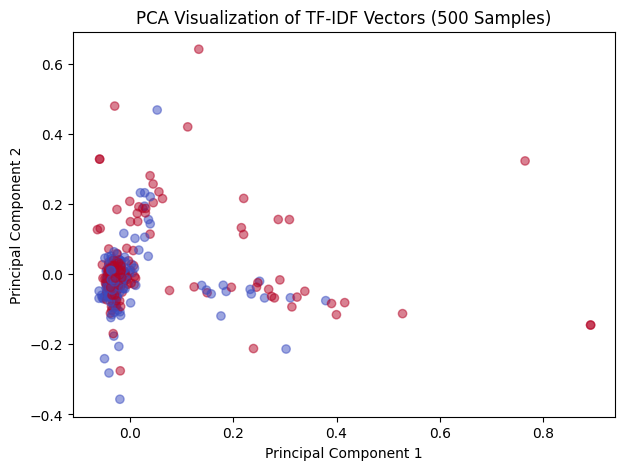

Top 10 TF-IDF features:
['aaa' 'aaaa' 'aaaaaaaa' 'aaaaaaaaaaaaaa' 'aaaaaaaaaaaaaaaahhhhhhhhhh'
 'aaaaaaaaaaaaahhhh' 'aaaaaaaaaaaaahhhhhhhhhhhhhhhhhh'
 'aaaaaaaaaaaaarrrrgggghhhh' 'aaaaaaaaaahhhhhhhhhhhrrrrrrggggg'
 'aaaaaaaaaaw' 'aaaaaaaaages' 'aaaaaaaaah' 'aaaaaaaaand'
 'aaaaaaaaarghhhhhhhhhhh' 'aaaaaaaaaw' 'aaaaaaaah' 'aaaaaaaahhhhh'
 'aaaaaaand' 'aaaaaah' 'aaaaah' 'aaaaahhhh' 'aaaaand' 'aaaah' 'aaaahhh'
 'aaaahhhh' 'aaaahhhhh' 'aaaand' 'aaaargh' 'aaaaw' 'aaagh' 'aaah' 'aaahh'
 'aaahhh' 'aaahhhh' 'aaahhhhh' 'aaand' 'aaargh' 'aaarrrggg' 'aaaw'
 'aaawww' 'aaawwww' 'aah' 'aahh' 'aahhh' 'aahhhh' 'aaliyah' 'aam' 'aampd'
 'aampe' 'aand' 'aar' 'aargh' 'aaron' 'aaw' 'aawww' 'aawwww' 'ab'
 'abandon' 'abandoned' 'abang' 'abba' 'abbey' 'abby' 'abc' 'abdomen'
 'abducted' 'aber' 'aberdeen' 'abi' 'ability' 'abis' 'abit' 'abitur'
 'able' 'ableton' 'abnormally' 'aboard' 'aboriginal' 'abort' 'abortion'
 'abou' 'abouts' 'aboutvetmed' 'abrams' 'abroad' 'absence' 'absent'
 'absinthe' 'abslutely' 'absofu

In [25]:
## Task-2

# =========================================
# ✅ Task 2 — Optimized Text Representation (Small Sample)
# =========================================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("\n--- Task 2: Optimized TF-IDF Representation ---")

df=pd.read_csv('/content/processed_sentiment140.csv')
# 1️⃣ Use a smaller random sample for fast processing
sample_df = df.sample(n=100000, random_state=42)   # use 10k rows instead of 1.6M
texts = sample_df["text_final"].astype(str)
labels = sample_df["target_encoded"]

# 2️⃣ TF-IDF Representation
max_features = 20000   # limit vocabulary for speed and stability
vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)

print("✅ TF-IDF matrix shape:", X_tfidf.shape)

# 3️⃣ Optional: PCA for visualization
try:
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_tfidf.toarray()[:500])  # only first 500 samples for speed
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels[:500], cmap='coolwarm', alpha=0.5)
    plt.title("PCA Visualization of TF-IDF Vectors (500 Samples)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()
except Exception as e:
    print(f"⚠️ PCA visualization skipped: {e}")

# 4️⃣ Summary
print("Top 10 TF-IDF features:")
print(vectorizer.get_feature_names_out()[:400])


# Save the DataFrame to a CSV file
sample_df.to_csv('sample_df.csv', index=False)

print("DataFrame saved to processed_sentiment140.csv")


--- Task 3: Baseline Deep Learning Model (BiLSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6641 - loss: 0.5887 - val_accuracy: 0.7602 - val_loss: 0.5001
Epoch 2/3
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7806 - loss: 0.4675 - val_accuracy: 0.7656 - val_loss: 0.4884
Epoch 3/3
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7967 - loss: 0.4345 - val_accuracy: 0.7651 - val_loss: 0.4932
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

--- Evaluation Metrics ---
Accuracy: 0.7625
F1-Score: 0.7683

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      7482
           1       0.75      0.79      0.77      7518

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000



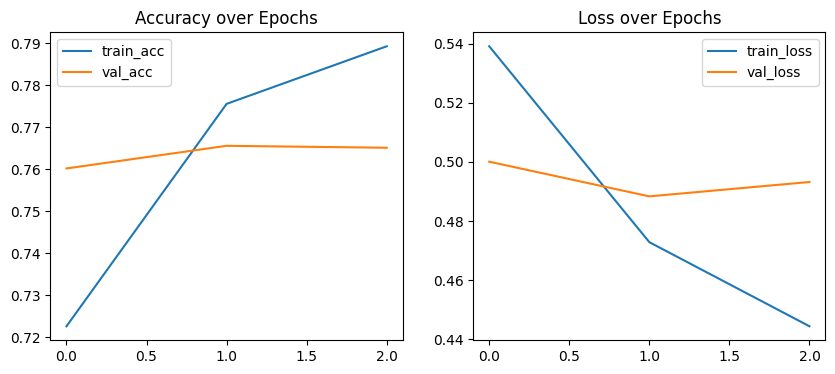

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,170,629 (4.47 MB)

 Trainable params: 390,209 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 780,420 (2.98 MB)

In [26]:
## Task-3

# =========================================
# ✅ Task 3 — Baseline Deep Learning Model (BiLSTM)
# =========================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("\n--- Task 3: Baseline Deep Learning Model (BiLSTM) ---")

# 1️⃣ Prepare data (small subset for faster training)
sample_df = pd.read_csv('/content/sample_df.csv')

texts = sample_df["text_final"].astype(str)
labels = sample_df["target_encoded"].astype(int)

# 2️⃣ Tokenization & padding
max_words = 5000   # vocab size
max_len = 50       # max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# 3️⃣ Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(padded, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4️⃣ Define baseline model (Bidirectional LSTM)
model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 5️⃣ Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 6️⃣ Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=64,
    verbose=1
)

# 7️⃣ Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n--- Evaluation Metrics ---")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 8️⃣ Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


model.summary()

In [27]:
# =========================================
# ✅ Task 4 — Feature Selection using Ant Colony Optimization (ACO)
# =========================================
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

print("\n--- Task 4: Feature Selection using Ant Colony Optimization (ACO) ---")

# ----------------------------------------------------
# Step 1️⃣ Load data (same as used in Task 3)
# ----------------------------------------------------
sample_df = pd.read_csv('/content/sample_df.csv')

texts = sample_df["text_final"].astype(str)
labels = sample_df["target_encoded"].astype(int)

# Train/Val/Test Split (same ratios)
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42, stratify=labels)
X_val_texts, X_test_texts, y_val, y_test = train_test_split(X_temp_texts, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# ----------------------------------------------------
# Step 2️⃣ TF-IDF Representation
# ----------------------------------------------------
max_features = 40000  # keep it reasonable for ACO
tfidf = TfidfVectorizer(max_features=max_features, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_val_tfidf = tfidf.transform(X_val_texts)
X_test_tfidf = tfidf.transform(X_test_texts)
feature_names = np.array(tfidf.get_feature_names_out())

# ----------------------------------------------------
# Step 3️⃣ Define helper: evaluate subset accuracy
# ----------------------------------------------------
def evaluate_subset(subset_indices, X_train, y_train, X_val, y_val):
    """Train a logistic regression model on a subset of features and return validation accuracy."""
    if len(subset_indices) == 0:
        return 0
    model = LogisticRegression(max_iter=300)
    model.fit(X_train[:, subset_indices], y_train)
    preds = model.predict(X_val[:, subset_indices])
    return accuracy_score(y_val, preds)

# ----------------------------------------------------
# Step 4️⃣ Define Optimized ACO function
# ----------------------------------------------------
def ant_colony_feature_selection(
    n_features, X_train, y_train, X_val, y_val,
    n_ants=15,
    n_iter=20,
    evap_rate=0.10,
    min_features=25000,
    max_features=40000,
    pheromone_boost=3.0
):
    """
    Optimized ACO for feature selection.

    Parameters:
    -----------
    n_features : int - Total number of features
    n_ants : int - Number of ants per iteration
    n_iter : int - Number of iterations
    evap_rate : float - Pheromone evaporation rate
    min_features : int - Minimum features to select (50% of total)
    max_features : int - Maximum features to select (80% of total)
    pheromone_boost : float - Pheromone reinforcement multiplier
    """
    pheromone = np.ones(n_features)
    best_subset, best_acc = [], 0

    for it in range(n_iter):
        print(f"\nIteration {it+1}/{n_iter}")
        all_subsets, all_accuracies = [], []

        for ant in range(n_ants):
            # Normalize pheromone to probabilities
            probs = pheromone / np.sum(pheromone)

            # Select number of features for this ant
            n_to_select = np.random.randint(min_features, max_features + 1)

            # Roulette wheel selection based on pheromone
            chosen_indices = np.random.choice(
                n_features,
                size=n_to_select,
                replace=False,
                p=probs
            )
            subset = chosen_indices

            # Evaluate this subset
            acc = evaluate_subset(subset, X_train, y_train, X_val, y_val)
            all_subsets.append(subset)
            all_accuracies.append(acc)
            print(f"🐜 Ant {ant+1}: selected {len(subset)} features, acc={acc:.4f}")

        # Find best ant in this iteration
        best_idx = np.argmax(all_accuracies)
        iteration_best_subset = all_subsets[best_idx]
        iteration_best_acc = all_accuracies[best_idx]

        # Pheromone evaporation
        pheromone = (1 - evap_rate) * pheromone

        # Pheromone deposit by best ant
        pheromone[iteration_best_subset] += pheromone_boost * iteration_best_acc

        # Also reward top 3 ants
        top_3_indices = np.argsort(all_accuracies)[-3:]
        for idx in top_3_indices[:-1]:
            pheromone[all_subsets[idx]] += (pheromone_boost * 0.3) * all_accuracies[idx]

        # Update global best
        if iteration_best_acc > best_acc:
            best_acc = iteration_best_acc
            best_subset = iteration_best_subset

        print(f"✓ Iteration best: {iteration_best_acc:.4f} ({len(iteration_best_subset)} features)")
        print(f"★ Global best: {best_acc:.4f} ({len(best_subset)} features)")

    return best_subset, best_acc

# ----------------------------------------------------
# Step 5️⃣ Run ACO
# ----------------------------------------------------
start_time = time.time()
selected_indices, aco_best_acc = ant_colony_feature_selection(
    X_train_tfidf.shape[1],
    X_train_tfidf, y_train,
    X_val_tfidf, y_val,
    n_ants=15,           # Fewer ants for efficiency
    n_iter=20,           # Fewer iterations (faster)
    evap_rate=0.10,      # Lower evaporation (more exploitation)
    min_features=25000,   # 50% of features minimum
    max_features=40000,   # 80% of features maximum
    pheromone_boost=3.0  # Moderate reinforcement
)
end_time = time.time()

selected_features = feature_names[selected_indices]
print(f"\n✅ ACO selected {len(selected_features)} features")
print("Example selected features:", selected_features[:20])
print(f"ACO Time: {end_time - start_time:.2f}s")
print(f"ACO Validation Accuracy: {aco_best_acc:.4f}")

# ----------------------------------------------------
# Step 6️⃣ Compare Model Performance Before vs After ACO
# ----------------------------------------------------
# Before ACO (all features)
base_model = LogisticRegression(max_iter=300)
base_model.fit(X_train_tfidf, y_train)
base_preds = base_model.predict(X_test_tfidf)
base_acc = accuracy_score(y_test, base_preds)
base_f1 = f1_score(y_test, base_preds)

# After ACO (selected features)
aco_model = LogisticRegression(max_iter=300)
aco_model.fit(X_train_tfidf[:, selected_indices], y_train)
aco_preds = aco_model.predict(X_test_tfidf[:, selected_indices])
aco_acc = accuracy_score(y_test, aco_preds)
aco_f1 = f1_score(y_test, aco_preds)

print("\n--- Final Model Comparison ---")
print(f"Before ACO: Accuracy={base_acc:.4f}, F1={base_f1:.4f}")
print(f"After  ACO: Accuracy={aco_acc:.4f}, F1={aco_f1:.4f}")
print(f"ACO Selected {len(selected_features)} / {len(feature_names)} features ({len(selected_features)/len(feature_names)*100:.1f}%)")

# Performance improvement
if aco_acc > base_acc:
    print(f"✅ ACO improved accuracy by {(aco_acc - base_acc)*100:.2f}%")
else:
    print(f"⚠️ ACO accuracy is {(base_acc - aco_acc)*100:.2f}% lower (try adjusting parameters)")

print(f"📊 Feature reduction: {(1 - len(selected_features)/len(feature_names))*100:.1f}%")


--- Task 4: Feature Selection using Ant Colony Optimization (ACO) ---

Iteration 1/20
🐜 Ant 1: selected 30921 features, acc=0.7207
🐜 Ant 2: selected 31995 features, acc=0.7209
🐜 Ant 3: selected 33729 features, acc=0.7343
🐜 Ant 4: selected 26152 features, acc=0.7183
🐜 Ant 5: selected 26546 features, acc=0.6860
🐜 Ant 6: selected 27232 features, acc=0.7159
🐜 Ant 7: selected 33411 features, acc=0.7346
🐜 Ant 8: selected 33110 features, acc=0.7297
🐜 Ant 9: selected 39653 features, acc=0.7555
🐜 Ant 10: selected 31102 features, acc=0.7293
🐜 Ant 11: selected 38833 features, acc=0.7543
🐜 Ant 12: selected 31233 features, acc=0.7263
🐜 Ant 13: selected 29439 features, acc=0.7195
🐜 Ant 14: selected 25664 features, acc=0.7033
🐜 Ant 15: selected 27020 features, acc=0.7031
✓ Iteration best: 0.7555 (39653 features)
★ Global best: 0.7555 (39653 features)

Iteration 2/20
🐜 Ant 1: selected 34682 features, acc=0.7417
🐜 Ant 2: selected 38780 features, acc=0.7478
🐜 Ant 3: selected 29396 features, acc=0.7252


In [28]:

# =========================================
# ✅ Task 5 — Model Parameter Optimization using Metaheuristics
# =========================================
import tensorflow as tf
import numpy as np, random, time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

print("\n--- Task 5: Hyperparameter Optimization using Metaheuristic Algorithms ---")

# ----------------------------------------------------
# Step 1️⃣ Load preprocessed data (same as Task 3)
# ----------------------------------------------------
df = pd.read_csv('/content/sample_df.csv')
texts = df["text_final"].astype(str)
labels = df["target_encoded"].astype(int)

# Tokenize and pad
max_words, max_len = 5000, 50
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
seqs = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

# Split
X_train, X_temp, y_train, y_temp = train_test_split(padded, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# ----------------------------------------------------
# Step 2️⃣ Objective function
# ----------------------------------------------------
def build_and_eval(params):
    """Train BiLSTM for few epochs with given params and return val accuracy."""
    lr, dr, units, batch, opt_type = params
    if opt_type == 0: optimizer = Adam(learning_rate=lr)
    elif opt_type == 1: optimizer = RMSprop(learning_rate=lr)
    else: optimizer = SGD(learning_rate=lr, momentum=0.9)

    model = Sequential([
        Embedding(max_words, 64, input_length=max_len),
        Bidirectional(LSTM(int(units), return_sequences=False)),
        Dropout(dr),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    h = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=2, batch_size=int(batch), verbose=0)
    return h.history['val_accuracy'][-1]

# Helper to clip parameters inside allowed bounds
def clip_params(p):
    p[0] = np.clip(p[0], 1e-5, 1e-2)
    p[1] = np.clip(p[1], 0.1, 0.5)
    p[2] = np.clip(p[2], 32, 256)
    p[3] = int(min(64, max(16, round(p[3]/16)*16)))
    p[4] = int(np.clip(round(p[4]), 0, 2))
    return p

# ----------------------------------------------------
# Step 3️⃣ Metaheuristics
# ----------------------------------------------------
def PSO(n_particles=5, iters=5):
    w, c1, c2 = 0.7, 1.5, 1.5
    dim = 5
    pos = np.random.rand(n_particles, dim)
    pos[:,0] = 1e-5 + pos[:,0]*(1e-2-1e-5)
    pos[:,1] = 0.1 + pos[:,1]*0.4
    pos[:,2] = 32 + pos[:,2]*224
    pos[:,3] = 16 + pos[:,3]*48
    pos[:,4] = np.random.randint(0,3,n_particles)

    vel = np.zeros_like(pos)
    pbest, pbest_score = pos.copy(), np.zeros(n_particles)
    for i in range(n_particles):
        pbest_score[i] = build_and_eval(clip_params(pos[i].copy()))
    gbest_idx = np.argmax(pbest_score)
    gbest, gbest_score = pbest[gbest_idx].copy(), pbest_score[gbest_idx]
    print(f"PSO initial best acc={gbest_score:.4f}")

    for t in range(iters):
        for i in range(n_particles):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            vel[i] = w*vel[i] + c1*r1*(pbest[i]-pos[i]) + c2*r2*(gbest-pos[i])
            pos[i] = clip_params(pos[i]+vel[i])
            score = build_and_eval(pos[i])
            if score > pbest_score[i]:
                pbest[i], pbest_score[i] = pos[i].copy(), score
        gbest_idx = np.argmax(pbest_score)
        if pbest_score[gbest_idx] > gbest_score:
            gbest, gbest_score = pbest[gbest_idx].copy(), pbest_score[gbest_idx]
        print(f"Iter {t+1}/{iters} best acc={gbest_score:.4f}")
    return gbest, gbest_score

def SimulatedAnnealing(iters=5, T0=1.0, alpha=0.85):
    curr = np.array([1e-3, 0.3, 128, 32, 0])
    curr_score = build_and_eval(curr)
    best, best_score = curr.copy(), curr_score
    T = T0
    for t in range(iters):
        cand = clip_params(curr + np.random.normal(0, [1e-3,0.05,30,8,1]))
        cand_score = build_and_eval(cand)
        if cand_score > curr_score or np.random.rand() < np.exp((cand_score-curr_score)/T):
            curr, curr_score = cand, cand_score
        if curr_score > best_score:
            best, best_score = curr.copy(), curr_score
        T *= alpha
        print(f"SA iter {t+1}/{iters} acc={best_score:.4f}")
    return best, best_score

def TabuSearch(iters=5, tabu_size=3):
    curr = np.array([1e-3, 0.3, 128, 32, 0])
    curr_score = build_and_eval(curr)
    best, best_score = curr.copy(), curr_score
    tabu = []
    for t in range(iters):
        neighbors = [clip_params(curr + np.random.normal(0, [1e-3,0.05,30,8,1])) for _ in range(4)]
        scores = [build_and_eval(n) if list(n) not in tabu else 0 for n in neighbors]
        best_n = neighbors[np.argmax(scores)]
        best_n_score = max(scores)
        tabu.append(list(best_n))
        if len(tabu)>tabu_size: tabu.pop(0)
        if best_n_score > best_score:
            best, best_score = best_n.copy(), best_n_score
        curr = best_n
        print(f"TS iter {t+1}/{iters} acc={best_score:.4f}")
    return best, best_score

def BatAlgorithm(n_bats=5, iters=5, fmin=0, fmax=2):
    bats = np.random.rand(n_bats,5)
    bats[:,0] = 1e-5 + bats[:,0]*(1e-2-1e-5)
    bats[:,1] = 0.1 + bats[:,1]*0.4
    bats[:,2] = 32 + bats[:,2]*224
    bats[:,3] = 16 + bats[:,3]*48
    bats[:,4] = np.random.randint(0,3,n_bats)
    vel = np.zeros_like(bats)
    loud, pulse = np.ones(n_bats)*0.5, np.ones(n_bats)*0.5
    scores = np.array([build_and_eval(clip_params(b)) for b in bats])
    best_idx = np.argmax(scores)
    best, best_score = bats[best_idx].copy(), scores[best_idx]

    for t in range(iters):
        for i in range(n_bats):
            f = fmin + (fmax-fmin)*np.random.rand()
            vel[i] += (bats[i]-best)*f
            new = clip_params(bats[i]+vel[i])
            if np.random.rand() > pulse[i]:
                new = clip_params(best + 0.001*np.random.randn(5))
            new_score = build_and_eval(new)
            if new_score > scores[i] and np.random.rand() < loud[i]:
                bats[i], scores[i] = new, new_score
                loud[i] *= 0.9
                pulse[i] = 0.9*pulse[i]
            if new_score > best_score:
                best, best_score = new.copy(), new_score
        print(f"BA iter {t+1}/{iters} acc={best_score:.4f}")
    return best, best_score

# ----------------------------------------------------
# Step 4️⃣ Run and Compare
# ----------------------------------------------------
results = []
start=time.time(); pso_best, pso_acc=PSO(); results.append(["PSO",pso_acc,pso_best,time.time()-start])
start=time.time(); sa_best, sa_acc=SimulatedAnnealing(); results.append(["SA",sa_acc,sa_best,time.time()-start])
start=time.time(); ts_best, ts_acc=TabuSearch(); results.append(["TS",ts_acc,ts_best,time.time()-start])
start=time.time(); ba_best, ba_acc=BatAlgorithm(); results.append(["BA",ba_acc,ba_best,time.time()-start])

# ----------------------------------------------------
# Step 5️⃣ Summary Table
# ----------------------------------------------------
summary = pd.DataFrame(results, columns=["Algorithm","Best Accuracy","Best Params","Time (s)"])
print("\n--- Metaheuristic Optimization Summary ---")
print(summary.to_string(index=False))



--- Task 5: Hyperparameter Optimization using Metaheuristic Algorithms ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


PSO initial best acc=0.7677
Iter 1/5 best acc=0.7695
Iter 2/5 best acc=0.7695
Iter 3/5 best acc=0.7695
Iter 4/5 best acc=0.7699
Iter 5/5 best acc=0.7699
SA iter 1/5 acc=0.7680
SA iter 2/5 acc=0.7680
SA iter 3/5 acc=0.7680
SA iter 4/5 acc=0.7680
SA iter 5/5 acc=0.7680
TS iter 1/5 acc=0.7677
TS iter 2/5 acc=0.7677
TS iter 3/5 acc=0.7696
TS iter 4/5 acc=0.7696
TS iter 5/5 acc=0.7696
BA iter 1/5 acc=0.7693
BA iter 2/5 acc=0.7693
BA iter 3/5 acc=0.7693
BA iter 4/5 acc=0.7693
BA iter 5/5 acc=0.7693

--- Metaheuristic Optimization Summary ---
Algorithm  Best Accuracy                                                                Best Params    Time (s)
      PSO       0.769867  [0.004447754628449016, 0.13206661636705053, 92.69961903243852, 32.0, 1.0] 1426.432383
       SA       0.768000                                             [0.001, 0.3, 128.0, 32.0, 0.0]  280.278621
       TS       0.769600 [0.002379213135769614, 0.38473308921008464, 101.64321218821846, 64.0, 1.0]  666.038778
       BA 